In [1]:
%env CC=gcc-11
%env CXX=g++-11

env: CC=gcc-11
env: CXX=g++-11


In [2]:
DATASET_NAME="pick_miss_cup_autoencoder"

## Intorduction

As in data analysis we first need to load the data and perform all the normalization and optimizations. The normalized data after all will be passed through encoder part of trained autoencoder just to get only relavent features in the data. 

So let's start with data loading:

##### Normal data

In [3]:
import pandas

DATA = pandas.read_csv('../../../robot-data/new_data/normal/merged_normal_pick.csv')
DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,shoulder2_joint position,torso_joint position,left_wheel_joint effort,right_finger_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity
0,4,284,0.264902,1.264027e-02,12,6456,0.071533,0,0,0,...,2.183829,0.301,0.0,-0.02690,0.0,-0.064453,92.853043,0.032227,0.0,0.0
1,5,355,0.200013,4.539819e-05,14,7532,0.069651,1,93,0,...,2.183829,0.301,0.0,-0.02421,0.0,-0.080566,82.853053,0.008057,0.0,0.0
2,5,355,0.201024,3.146104e-06,12,6456,0.087292,0,0,0,...,2.183829,0.298,0.0,-0.02421,0.0,0.000000,88.853035,0.052368,0.0,0.0
3,5,355,0.200395,2.509922e-06,11,5918,0.086181,1,93,0,...,2.183829,0.303,0.0,-0.02421,0.0,0.000000,104.853008,0.032227,0.0,0.0
4,5,355,0.200118,1.580059e-06,13,6994,0.081231,0,0,1,...,2.183829,0.299,0.0,-0.02690,0.0,-0.112793,90.853009,0.008057,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,5,610,0.200005,3.723324e-07,15,8070,0.067330,0,0,1,...,2.183880,0.277,0.0,0.46268,0.0,0.000000,-85.098008,0.056396,0.0,0.0
1672,5,610,0.200002,2.663688e-08,15,8070,0.066322,1,93,2,...,2.183880,0.272,0.0,0.45999,0.0,0.000000,-78.543533,0.060425,0.0,0.0
1673,5,610,0.199537,8.526598e-07,15,8070,0.068983,0,0,1,...,2.183880,0.268,0.0,0.45999,0.0,0.048340,-75.750176,0.060425,0.0,0.0
1674,5,610,0.198214,1.329264e-05,15,8070,0.066772,1,93,1,...,2.183880,0.263,0.0,0.45999,0.0,0.000000,-72.689521,0.060425,0.0,0.0


##### Anomaly data

In [4]:
ANOMALY_DATA = pandas.read_csv('../../../robot-data/new_data/test/merged_pick_miss_cup.csv')
ANOMALY_DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,left_wheel_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity,right_wheel_joint velocity,shoulder1_joint velocity,shoulder2_joint velocity
0,6,120,0.190663,1.291337e-02,12,6456,0.063092,0,0,0,...,0.0,0.0,0.000000,-7.569872,0.000000,0.0,0.0,0.0,0.000000,0.0
1,5,100,0.199080,3.438309e-06,15,8070,0.065023,0,0,0,...,0.0,0.0,0.000000,-1.429256,0.008057,0.0,0.0,0.0,0.000000,0.0
2,5,100,0.200019,1.036475e-05,16,8608,0.064299,1,93,0,...,0.0,0.0,0.000000,-7.379467,0.000000,0.0,0.0,0.0,0.000000,0.0
3,5,100,0.199980,1.747321e-05,14,7532,0.070981,0,0,0,...,0.0,0.0,0.000000,-1.260519,0.008057,0.0,0.0,0.0,0.000000,0.0
4,5,100,0.200011,4.932453e-08,15,8070,0.064694,1,93,0,...,0.0,0.0,0.000000,-3.198487,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,5,360,0.199993,1.427605e-08,15,8070,0.068399,0,0,1,...,0.0,0.0,-0.064453,-81.999998,0.056396,0.0,0.0,0.0,0.000000,0.0
1686,5,360,0.199986,9.456916e-08,14,7532,0.069274,1,93,0,...,0.0,0.0,-0.128906,-87.999980,0.056396,0.0,0.0,0.0,0.000000,0.0
1687,5,360,0.199958,1.688842e-08,14,7532,0.074080,0,0,0,...,0.0,0.0,-0.064453,-82.051771,0.056396,0.0,0.0,0.0,0.000000,0.0
1688,5,360,0.199994,1.212901e-06,14,7532,0.067554,1,93,1,...,0.0,0.0,-0.048340,-91.781406,0.056396,0.0,0.0,0.0,0.000209,0.0


For normalization we choose `MinMaxScaler` with value range between $\left[1, -1\right]$

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm
import numpy as np
import heapq
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime
from IPython.display import Image
import math
import pickle

## Data processing

#### Data processing utils

In [6]:
scalers = {}

def normalize_data(original_data):
    """
    This function used for normalizing data, with MinMaxScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def std_normalize_data(data):
    """
    This function used for normalizing data, with StandardScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = data
    for i in data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    """
    This function is normalization inverse function.
    :param columns: orinal columns names, used for taking correct scaler that was saved while normalization
    :param reconstructed_data: normalized data
    :return: unnormalized data 
    """
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)

def draw_from_GMM(mus, sigmas, thetas, numOfDraws = 1):
    """
    This function draws samples based on mu, sigma and theta of Gaussian Mixture Model
    :param mus: list of mus
    :param sigmas: list of sigmas
    :param thetas: list of thetas
    :param numOfDraws: number of draws from distribution
    :return: list of samples and list of lists of samples
    """
    gmm_res = []
    gaussians = []
    for j in range(len(thetas[0])):
        gaussians.append([])
    for i in tqdm(range(len(mus))):
        mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
        samples = np.random.normal(mus[i,mixture_idx], sigmas[i,mixture_idx], size=numOfDraws)
        sample_index = np.random.choice(len(samples), size=1, replace=True)[0]
        gmm_res.append(samples[sample_index]) 
        gaussians[mixture_idx].append(samples[sample_index])
    return gmm_res, gaussians

def calc_lppd(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in tqdm(range(len(y))):
        ppd_res = 0
        for i in range(len(mus)):
            mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
            ppd_res += norm.pdf(y[n], mus[i, mixture_idx], sigmas[i, mixture_idx])
        lppds.append(math.log(ppd_res/len(mus))) 
        
    return lppds, np.sum(lppds)

def calc_lppd_vec(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in range(len(y)):
        ppd_res = 0
        pdf = norm.pdf(y[n], mus, sigmas)
        ppd_res = np.sum(np.multiply(thetas, pdf))
        lppds.append(math.log(ppd_res/len(mus)))
    return lppds, np.sum(lppds)

def calc_lppd_vec_sliding_window(mu, sigma, theta, y, window_size=5):
    windows = np.lib.stride_tricks.sliding_window_view(y, window_size)
    wlppd = []
    for w in windows:
        lppds, lppd = calc_lppd_vec(mu, sigma, theta, w)
        wlppd.append(np.average(lppds))
    return wlppd, np.sum(wlppd)


#     """
#     Data split for train and labels with sliding window
#     :param data: original data
#     :param window: subsequence length
#     :return:
#     """
#     train_x = data[:window + 1]
#     x, y = sliding_windows(train_x, 1)
#     train_x = Variable(torch.Tensor(np.array(x)))
#     train_y = Variable(torch.Tensor(np.array(y)))
#     return train_x, train_y


def sliding_windows(data, seq_length):
    """
    Sliding window transformation for the data
    :param data: original data
    :param seq_length: window size
    :return: two arrays of x and y
    """
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)



#### Train Autoencoder

In [10]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
seq_len = 300
reduced_features = 2

def train_autoencoder(data, layer_size=128):
    encoder = None
    if os.path.isdir('./stan/encoder_model.ml'):
        encoder = keras.models.load_model('./stan/encoder_model.ml')
    else:
        input_data = Input(shape=(data.shape[1],))
        encoded1 = Dense(layer_size, activation='relu')(input_data)
        encoded2 = Dense(reduced_features, activation='relu')(encoded1)
        decoded1 = Dense(layer_size, activation='relu')(encoded2)
        decoded2 = Dense(data.shape[1], activation=None)(decoded1)
        autoencoder = Model(input_data, decoded2)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        autoencoder.summary()
        autoencoder.fit(data, data,
                        epochs=500,
                        batch_size=16,
                        shuffle=True)
        encoder = Model(input_data, encoded2)
        encoder.save('./stan/encoder_model')
    return encoder

##### Choosing common columns

While looking on the data we saw that there are small difference in the columns of anomaly and normal data, so we tried to find common columns.

In [8]:
norm_data, columns = normalize_data(DATA.copy()).values, list(DATA.columns.values)

columns = DATA.columns
anomaly_columns = ANOMALY_DATA.columns
common_columns = np.intersect1d(columns, anomaly_columns)
common_columns = [x for _, x in sorted(zip(columns, common_columns), key=lambda pair: pair[0])]
anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[common_columns].values
print("Common columns:", anomaly_norm_data.shape)
norm_data = normalize_data(DATA[common_columns].copy())
print('Original dataset shape:', norm_data.shape)

Common columns: (1690, 249)
Original dataset shape: (1676, 249)


In [11]:
encoder = train_autoencoder(norm_data, norm_data.shape[1])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 249)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 249)               62250     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 500       
_________________________________________________________________
dense_6 (Dense)              (None, 249)               747       
_________________________________________________________________
dense_7 (Dense)              (None, 249)               62250     
Total params: 125,747
Trainable params: 125,747
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
105/105 [==============================] - 0s 2ms/step - loss: 0.4870
Epoch 2/500
105/105 [================

105/105 [==============================] - 0s 2ms/step - loss: 0.1859
Epoch 88/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1830
Epoch 89/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1799
Epoch 90/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1759
Epoch 91/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1749
Epoch 92/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1730
Epoch 93/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1721
Epoch 94/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1652
Epoch 95/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1659
Epoch 96/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1668
Epoch 97/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1612
Epoch 98/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1613
Epoch 99/500
105/

105/105 [==============================] - 0s 2ms/step - loss: 0.1471
Epoch 185/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1475
Epoch 186/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 187/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1440
Epoch 188/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1478
Epoch 189/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1465
Epoch 190/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1459
Epoch 191/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1466
Epoch 192/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1448
Epoch 193/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1470
Epoch 194/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1450
Epoch 195/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1443
Epoch 

105/105 [==============================] - 0s 2ms/step - loss: 0.1452
Epoch 282/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1426
Epoch 283/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1419
Epoch 284/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1434
Epoch 285/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1414
Epoch 286/500
105/105 [==============================] - 0s 1ms/step - loss: 0.1458
Epoch 287/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1462
Epoch 288/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1447
Epoch 289/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1428
Epoch 290/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1404
Epoch 291/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1438
Epoch 292/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1415
Epoch 

105/105 [==============================] - 0s 2ms/step - loss: 0.1357
Epoch 379/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1377
Epoch 380/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1394
Epoch 381/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1367
Epoch 382/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1380
Epoch 383/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1406
Epoch 384/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1390
Epoch 385/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1368
Epoch 386/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1387
Epoch 387/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1393
Epoch 388/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1386
Epoch 389/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1385
Epoch 

105/105 [==============================] - 0s 2ms/step - loss: 0.1339
Epoch 476/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1307
Epoch 477/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1314
Epoch 478/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1295
Epoch 479/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1317
Epoch 480/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1301
Epoch 481/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1288
Epoch 482/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1279
Epoch 483/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1291
Epoch 484/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1290
Epoch 485/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1285
Epoch 486/500
105/105 [==============================] - 0s 2ms/step - loss: 0.1324
Epoch 

In [12]:
new_data = encoder.predict(norm_data)
encoder.summary()
weights = encoder.get_weights()[1]
print(weights.shape, weights)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 249)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 249)               62250     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 500       
Total params: 62,750
Trainable params: 62,750
Non-trainable params: 0
_________________________________________________________________
(249,) [-1.07931090e-03  4.88420716e-03 -3.40632687e-04 -2.76063394e-04
  1.75853108e-06  9.31544509e-03  9.03617707e-04  2.85010086e-04
  6.30990718e-04  7.40467571e-03 -6.22568140e-03  6.23673259e-05
 -8.88646755e-04  6.44016638e-03 -6.13554264e-04  0.00000000e+00
 -4.64183831e-04  4.67780483e-05  1.55474627e-04  6.39263482e-04
 -7.17908784e-04  8.31594749e-04  3.90145066e-03 -6.3

#### Taking most important weights

In [13]:
most_important = [[i, weights[i]] for i in heapq.nlargest(12, range(len(weights)), weights.__getitem__)]
most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
most_important_data_fragment = pandas.DataFrame(most_important, columns=['Index of column', 'PCA coefficient'])
most_important_data_fragment

,Index of column,PCA coefficient
0,73,0.010583
1,241,0.009952
2,237,0.009735
3,5,0.009315
4,78,0.009273
5,95,0.009272
6,151,0.009217
7,142,0.008479
8,172,0.008283
9,173,0.008265


In [14]:
initial_feature_names = DATA.columns
most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(len(most_important))]
most_important_column_names_df = pandas.DataFrame(most_important_column_names, columns=['Column name'])
pandas.set_option("max_colwidth", 700)
most_important_column_names_df

,Column name
0,/joint_states My_Traffic(Bytes)
1,torso_joint position
2,rotation1_joint position
3,/arm_trajectory_controller/state My_Traffic(Bytes)
4,Var_Consecutive(/kinect2/bond)
5,/kinect2/hd/image_mono My_Traffic(Bytes)
6,Counter(/kinect2/sd/image_depth/compressed)
7,Counter(/kinect2/sd/image_color_rect)
8,Counter(/mobile_base_controller/odom)
9,/mobile_base_controller/odom My_Traffic(Bytes)


Density estimation
measure density of the data path (Deep density estimation)
simulation base inference

(1. PCA 2. To choose part of columns 3. Run pca again on chosen columns)
4. * Use autoencoder to reduce dimensions 
5. Read about dimensionality reduction
6. Map data to reduced dimentions
7. GMM with 2d
(PCA?) -> Autoencoder -> (normalizing flow for density estimation?) -> GMM-2D

1


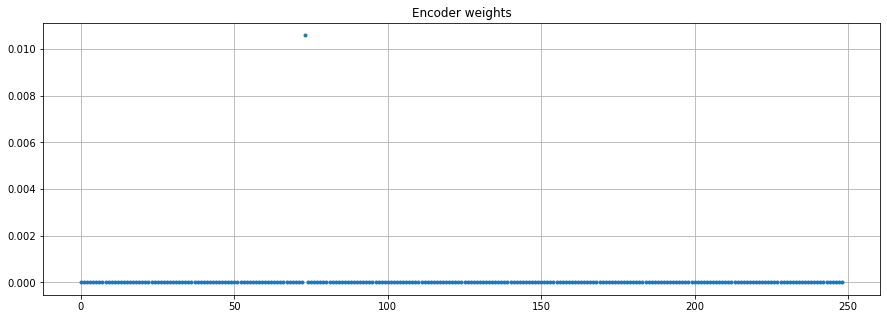

In [15]:
important_weights = np.where(abs(weights) <= 0.01, 0, weights)
print(np.count_nonzero(important_weights))
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(important_weights.T), ".")
axs.set_title('Encoder weights')
plt.grid()
plt.show()
plt.close()

As the result of filtering we got only 12 points which mean that we have only 12 features of the original data will play major role in the linear transformation on the data we perform next.

(1676, 2)
(1690, 2)


Text(0.5, 1.0, 'Lineary transformed data')

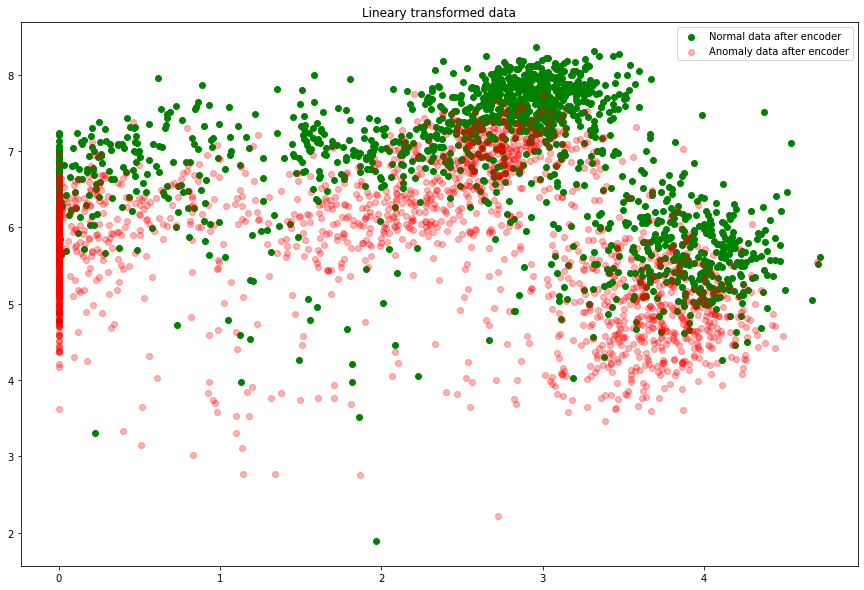

In [16]:
anomaly_encode = encoder.predict(anomaly_norm_data)
fig, axs = plt.subplots(1, figsize=(15, 10))
normal_encoded_data = new_data 
anomaly_encoded_data = anomaly_encode 
print(normal_encoded_data.shape)
print(anomaly_encoded_data.shape)
axs.scatter(normal_encoded_data[:,0], normal_encoded_data[:,1], color="g", label="Normal data after encoder")
axs.scatter(anomaly_encoded_data[:,0], anomaly_encoded_data[:,1], color="r", alpha=0.3, label="Anomaly data after encoder")
axs.legend()
axs.set_title('Lineary transformed data')

In [17]:
normal_encoded_data_df = pandas.DataFrame(normal_encoded_data, columns=['y1', 'y2'])
normal_encoded_data_df

,y1,y2
0,0.899205,7.326592
1,3.438325,8.240073
2,3.238407,7.854170
3,2.229847,4.058132
4,2.763784,6.717824
...,...,...
1671,0.000000,7.007314
1672,2.757974,7.849017
1673,3.275771,7.641079
1674,2.789933,7.804907


Just to understand behaviour of the data we decided to plot histogram

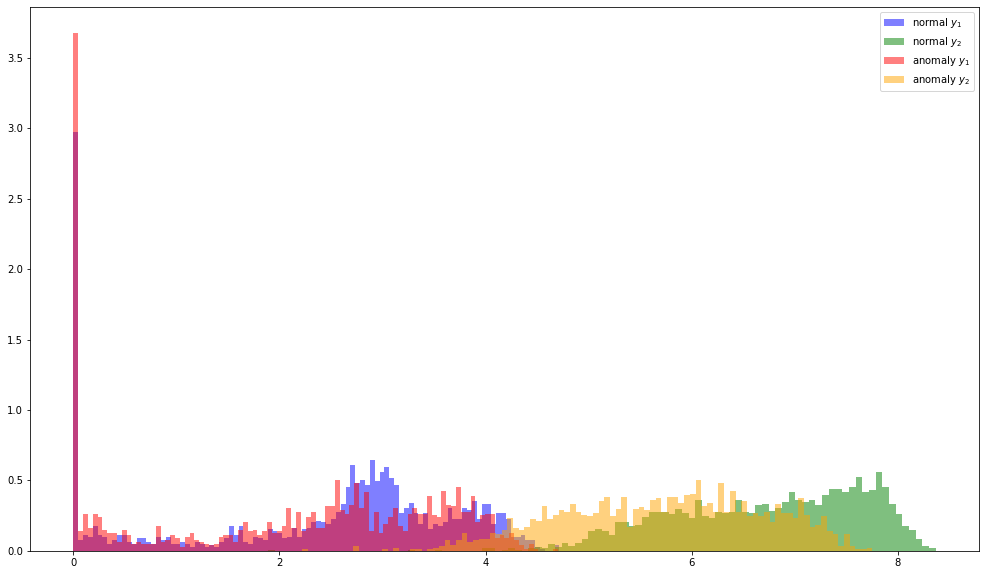

In [19]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(list(normal_encoded_data[:, 0]), 100, facecolor='b', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
n, bins, patches = axs.hist(list(normal_encoded_data[:, 1]), 100, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal $y_2$")
n, bins, patches = axs.hist(list(anomaly_encoded_data[:, 0]), 100, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly $y_1$")
n, bins, patches = axs.hist(list(anomaly_encoded_data[:, 1]), 100, facecolor='orange', alpha=0.5, density=True, stacked=True, label="anomaly $y_2$")
axs.legend()

To see the results more clear we will normilize the data again to be in range between 0 and 1

## Model

Density estimation
DP-GMM or HDP



In [20]:
import pystan

In [21]:
GMM_MODEL = """
data {
    int<lower=0> N;            // Number of measurements
    vector[N] y;                 // Data
    
    int<lower=1> k;// Number of Gaussians

    real<lower=0> mu_loc_prior;
    real<lower=0> mu_shape_prior;
    real<lower=0> sigma_loc_prior;
    real<lower=0> sigma_shape_prior;

    real<lower=0> theta_loc_prior;
    real<lower=0> theta_scale_prior;
}
parameters {
    ordered[k] mu;
    real<lower=0> sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    sigma ~ normal(sigma_loc_prior, sigma_shape_prior);
    mu ~ normal(mu_loc_prior, mu_shape_prior);
    theta ~ beta(theta_loc_prior, theta_scale_prior);
    
    for (n in 1:N) {
        for (i in 1:k) {
            ll[i] = log(theta[i]) + normal_lpdf(y[n] | mu[i], sigma[i]);
        }
        target += log_sum_exp(ll);
    }       
}
"""

In [22]:
model = None
if os.path.isfile('./stan/model.pkl'):
    model = pickle.load(open('./stan/model.pkl', 'rb'))
else:  
    model = pystan.StanModel(model_code=GMM_MODEL, verbose=False, extra_compile_args=["-w"])
    with open('./stan/model.pkl', 'wb') as f:
        pickle.dump(model, f)

##### Real data run

We will take only one dimension of our two dimensional dataset and try the model on it

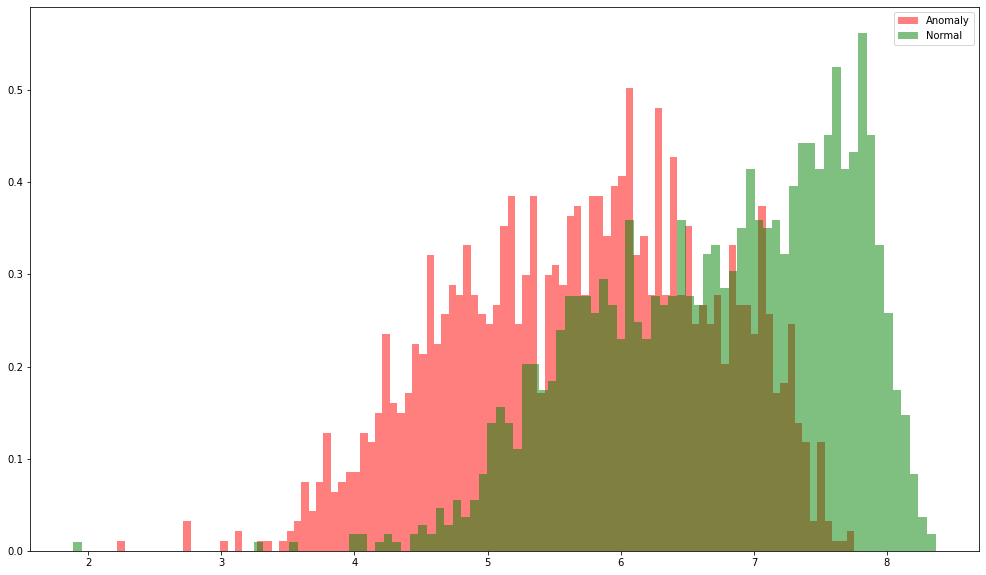

In [23]:
stan_normal_data = normal_encoded_data[:,1]
stan_anomaly_data = anomaly_encoded_data[:,1]
fig, axs = plt.subplots(1, figsize=(17, 10))
n, anomaly_bins, patches = axs.hist(stan_anomaly_data, 100, facecolor='r', alpha=0.5, density=True, stacked=True, label="Anomaly")
n, norm_bins, patches = axs.hist(stan_normal_data, 100, facecolor='g', alpha=0.5, density=True, stacked=True, label="Normal")
axs.legend()

In [24]:
def plot_simulations(simulations, snd, sad):
    fig, axs = plt.subplots(2, figsize=(17, 17))
    n, bins, patches = axs[0].hist(sad, 200, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly")
    n, bins, patches = axs[0].hist(snd, 200, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal")
    n, bins, patches = axs[0].hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated")
    n, bins, patches = axs[1].hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated")
    axs[0].legend()
    axs[1].legend()
    plt.show()
    
def plot_lppd(lppds):
    fig, axs = plt.subplots(2, figsize=(17, 17))
    n, bins, patches = axs[0].hist(lppds, 200, alpha=0.5, density=True, stacked=True, label="lppd")
    axs[1].plot(range(len(lppds)), lppds, label="lppd")
    axs[0].legend()
    axs[1].legend()
    plt.show()

def train_and_plot(num_of_gaussians, data, anomaly_data):
    mu_loc_prior = 0;
    mu_shape_prior = 2;
    sigma_loc_prior = 0.1;
    sigma_shape_prior = 2;
    theta_loc_prior = 5;
    theta_scale_prior = 5;
    print(data.shape)
    st_data= {
        'N':data.shape[0],
        'y':data,
        'k': num_of_gaussians,
        'mu_loc_prior': mu_loc_prior,
        'mu_shape_prior': mu_shape_prior,
        'sigma_loc_prior': sigma_loc_prior,
        'sigma_shape_prior': sigma_shape_prior,
        'theta_loc_prior': theta_loc_prior,
        'theta_scale_prior': theta_scale_prior
    }
    fit = None
    if os.path.isfile('./stan/fit_' + DATASET_NAME+ '_' + str(num_of_gaussians) + '.pkl'):
        fit = pickle.load(open('./stan/fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'rb'))
    else:
        fit = model.sampling(data=st_data, iter=1000, verbose=False, n_jobs=-1)
        with open('./stan/fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'wb') as g:
            pickle.dump(fit, g)
    
    print(fit)
    samples = fit.extract(permuted=True)
    mu = samples['mu']
    sigma = samples['sigma']
    theta = samples['theta']
    print(np.mean(mu, axis=0))
    print(np.mean(sigma, axis=0))
    print(np.mean(theta, axis=0))
    
    return mu, sigma, theta
    

In [25]:
def simulation_and_lppd(mu, sigma, theta, data, anomaly_data):
    simulations, _ = draw_from_GMM(mu, sigma, theta, 1000)
    plot_simulations(simulations, data, anomaly_data)
    lppds, lppd = calc_lppd_vec(mu, sigma, theta, anomaly_data)
    print(lppd)
    plot_lppd(lppds)
    return simulations, lppds

#### 5 Gaussians

(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 9179.03it/s]


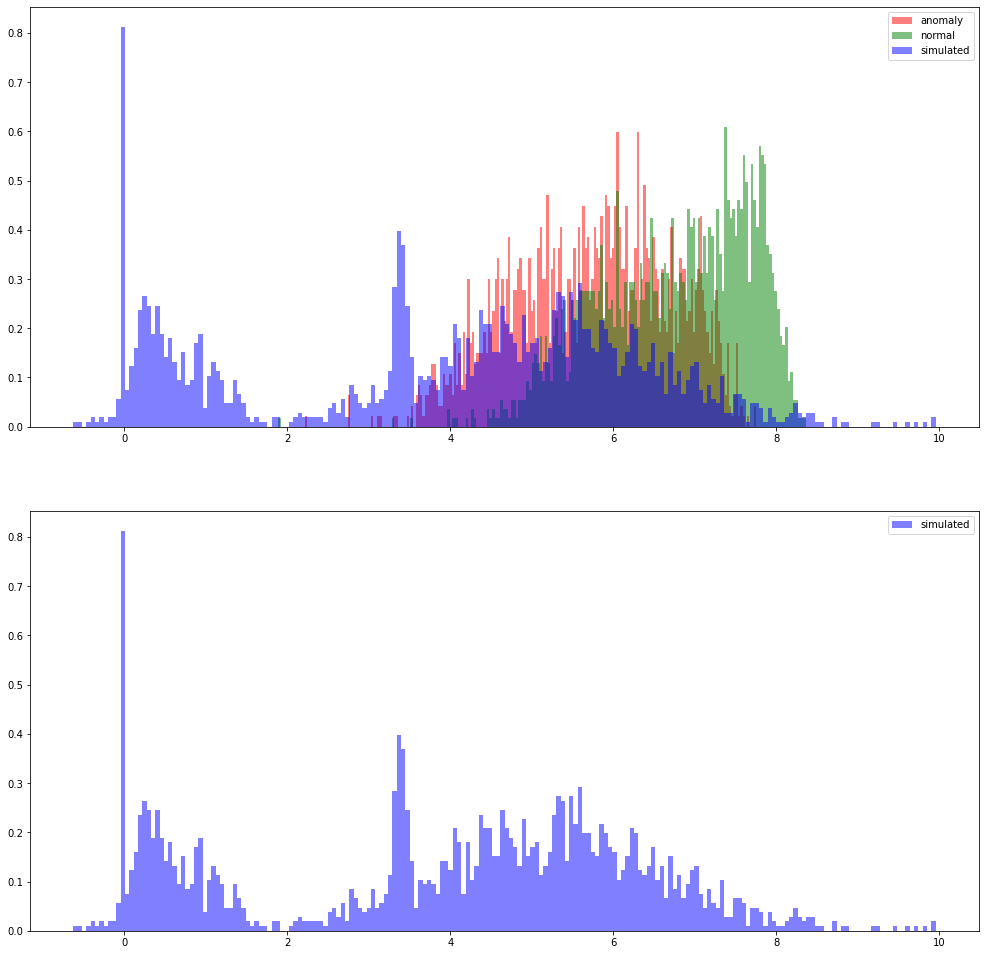

-3254.573215236943


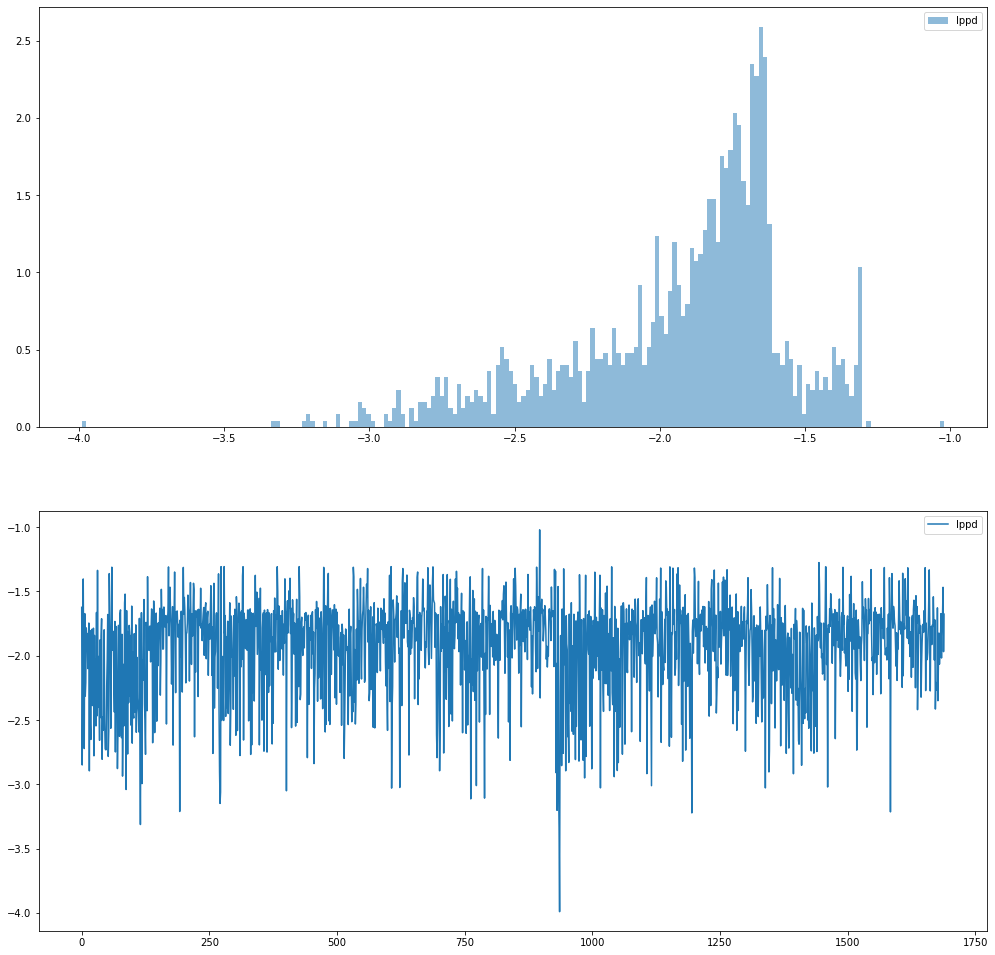

In [26]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
sim, lppds = simulation_and_lppd(mu, sigma, theta, stan_normal_data, stan_anomaly_data)

In [27]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_lppds = []
for offset_size in range(0, len(stan_anomaly_data), 100):
    wlppd, _ = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_anomaly_data[offset_size:offset_size + 100], 5)
    all_lppds.append(wlppd)


(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93

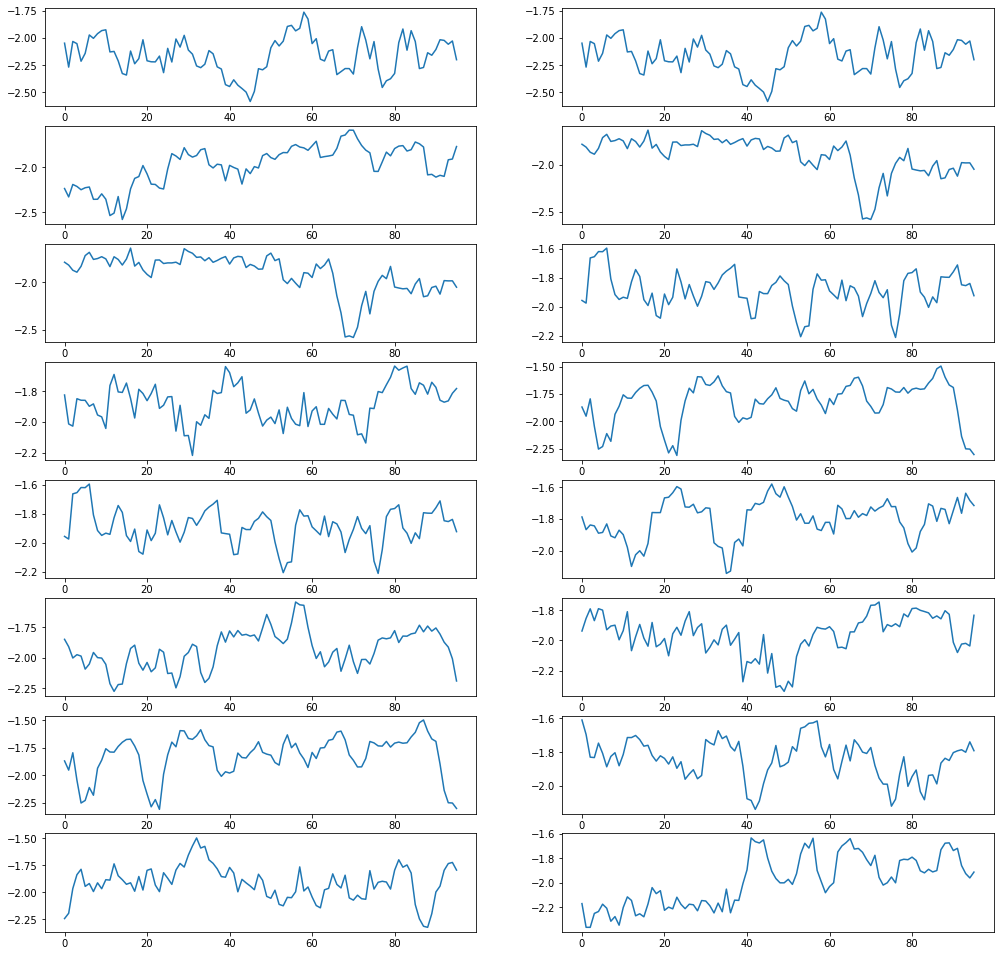

In [28]:
plots_shape = (2,2)
if len(all_lppds) % 3 == 0:
    plots_shape = (int(len(all_lppds)/3), 3)
else:
    plots_shape = (int(len(all_lppds)/2), 2)
fig, axs = plt.subplots(plots_shape[0], plots_shape[1], figsize=(17, 17))
for i in range(plots_shape[0]):
    for j in range(plots_shape[1]):
        axs[i][j].plot(range(len(all_lppds[i * j + i])), all_lppds[i * j + i])
plt.show()

In [29]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_lppds = []
for offset_size in range(0, len(stan_anomaly_data), 100):
    lppds, lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, 
                                stan_normal_data[offset_size:offset_size + 100])
    all_lppds.append(lppds)

(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93

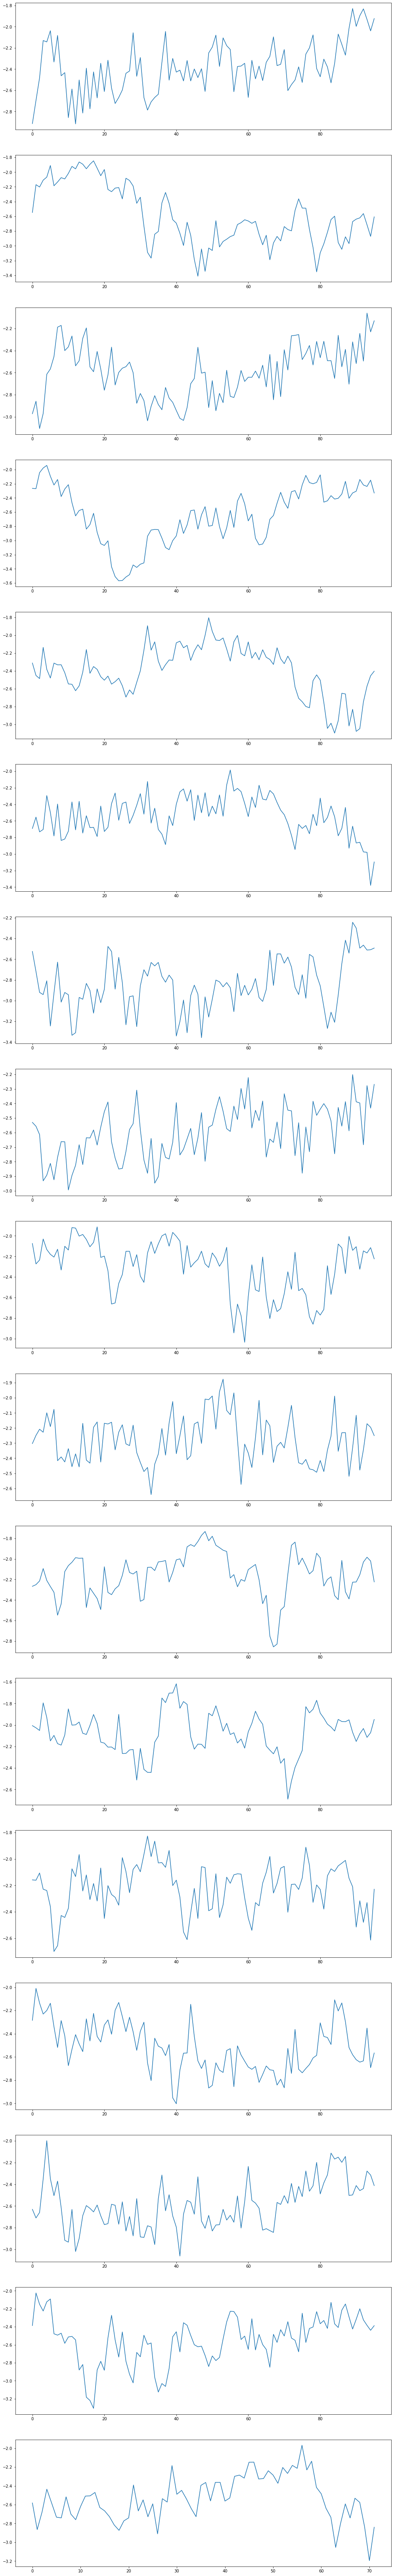

In [30]:
fig, axs = plt.subplots(int(len(all_lppds)), figsize=(17, 7*len(all_lppds)))
for i in range(int(len(all_lppds))):
    axs[i].plot(range(len(all_lppds[i])), all_lppds[i])
plt.show()

In [53]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_norm_lppds, lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_normal_data, 5)
all_anomaly_lppds, anom_lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_anomaly_data, 5)
print(mu.shape, sigma.shape, theta.shape)

(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93

Text(0.5, 1.0, 'LPPDs')

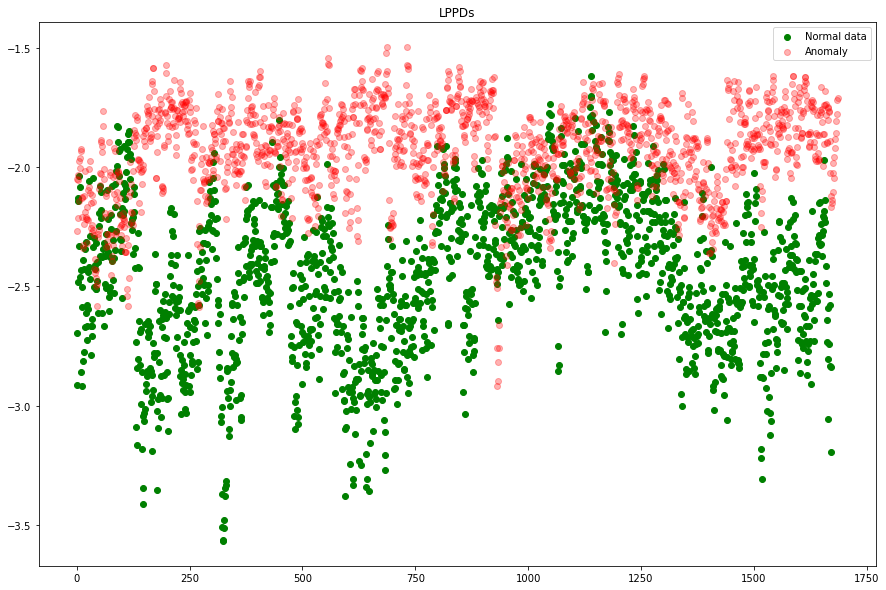

In [32]:
fig, axs = plt.subplots(1, figsize=(15, 10))
emptyData = [None] * (len(all_norm_lppds)-len(all_anomaly_lppds))
all_anomaly_lppds += emptyData
axs.scatter(range(len(all_norm_lppds)), all_norm_lppds, color="g", label="Normal data")
axs.scatter(range(len(all_anomaly_lppds)), all_anomaly_lppds, color="r",alpha=0.3, label="Anomaly")
axs.legend()
axs.set_title('LPPDs')

In [37]:
MILTI_DIM_GMM_MODEL = """
data {
    int<lower=1> D;            // Dimentions
    int<lower=0> N;            // Number of measurements
    vector[D] y[N];            // Data
    
    int<lower=1> k;// Number of Gaussians

}
parameters {
    vector[D] mu[k];
    vector<lower=0.0>[D] sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    
    for (n in 1:N) {
        for (m in 1:k) {
            ll[m] <- log(theta[m]);
            for (d in 1:D) {
                ll[m] <- ll[m] + normal_log(y[n, d], mu[m, d], sigma[m, d]);
            }
        }
        target += log_sum_exp(ll);
    }       
}
"""

In [38]:
model = None
if os.path.isfile('./stan/model_multigmm.pkl'):
    model = pickle.load(open('./stan/model_multigmm.pkl', 'rb'))
else:  
    model = pystan.StanModel(model_code=MILTI_DIM_GMM_MODEL, verbose=False, extra_compile_args=["-w"])
    with open('./stan/model_multigmm.pkl', 'wb') as f:
        pickle.dump(model, f)

In [39]:
def train_multi_gmm(num_of_gaussians, data):
    print(data.shape)
    st_data= {
        'N':data.shape[0],
        'D': data.shape[1],
        'y': data,
        'k': num_of_gaussians
    }
    fit = None
    if os.path.isfile('./stan/multi_fit_' + DATASET_NAME+ '_' + str(num_of_gaussians) + '_' + str(data.shape[1]) + '.pkl'):
        fit = pickle.load(open('./stan/multi_fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '_' + str(data.shape[1]) + '.pkl', 'rb'))
    else:
        fit = model.sampling(data=st_data, iter=1000, verbose=False, n_jobs=-1)
        with open('./stan/multi_fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '_' + str(data.shape[1]) + '.pkl', 'wb') as g:
            pickle.dump(fit, g)
    
    print(fit)
    samples = fit.extract(permuted=True)
    mu = samples['mu']
    sigma = samples['sigma']
    theta = samples['theta']
    print(np.mean(mu, axis=0))
    print(np.mean(sigma, axis=0))
    print(np.mean(theta, axis=0))
    
    return mu, sigma, theta
    

In [ ]:
mu, sigma, theta = train_multi_gmm(2, norm_data)

In [54]:
from scipy.stats import multivariate_normal
# var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
# var.pdf([1,0])

def calc_lppd_vec_multi(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in range(len(y)):
        ppd_res = 0
        var = multivariate_normal(mean=mus[n].reshape(mus[n].shape[0] * mus[n].shape[1]), cov=sigmas[n])
        pdf = var.pdf(y[n])
        ppd_res = np.sum(np.multiply(thetas, pdf))
        lppds.append(math.log(ppd_res/len(mus)))
    return lppds, np.sum(lppds)

def calc_lppd_vec_sliding_window_multi(mu, sigma, theta, y, window_size=5):
    windows = np.lib.stride_tricks.sliding_window_view(y, window_size)
    wlppd = []
    for w in windows:
        lppds, lppd = calc_lppd_vec_multi(mu, sigma, theta, w)
        wlppd.append(np.average(lppds))
    return wlppd, np.sum(wlppd)

In [55]:
mu, sigma , theta= train_multi_gmm(5, normal_encoded_data)


(1676, 2)
Inference for Stan model: anon_model_08e1c9a3e21e50322d00591c61dc7733.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%     50%     75%   97.5%  n_eff   Rhat
mu[1,1]      13.52   13.91  19.68  -2.72  -1.83    5.05   30.65    46.4      2 312.16
mu[2,1]       -5.6    5.97   8.44 -20.21 -12.21   -0.76  1.2e-9  1.2e-7      2  62.82
mu[3,1]       5.57   11.64  16.48 -15.34  -7.03    3.32    18.0   31.63      2  88.28
mu[4,1]       2.43    0.99   1.41   1.18   1.28    1.91     3.4    4.97      2  17.04
mu[5,1]       2.23    0.63   0.89   0.73   1.46    2.66    2.89    2.96      2  97.74
mu[1,2]      -2.41    5.62   7.96 -15.34  -8.76   -0.39    3.18    6.86      2  50.55
mu[2,2]      19.14   13.48  19.07   3.79    4.9   10.58   34.19   52.65      2  45.67
mu[3,2]      25.34   19.13  27.07   5.65   6.18   12.06   47.07   71.64      2 727.46
mu[4,2]       -2.5     8.9   

In [56]:
print(mu.shape, sigma.shape, theta.shape, normal_encoded_data.shape)
all_norm_lppds, lppd = calc_lppd_vec_sliding_window_multi(mu, sigma, theta, normal_encoded_data, (5, 2))
all_anomaly_lppds, anom_lppd = calc_lppd_vec_sliding_window_multi(mu, sigma, theta, anomaly_encoded_data, (5, 2))

(2000, 5, 2) (2000, 5, 2) (2000, 5) (1676, 2)


ValueError: Array 'cov' must be square if it is two dimensional, but cov.shape = (5, 2).